In [1]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msn
from copy import deepcopy
from warnings import filterwarnings
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [2]:
raw = pd.read_csv('Fruit.txt', sep='\t')
df = deepcopy(raw)

In [140]:
df.sample(6)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
11,1,apple,braeburn,172,7.1,7.6,0.92
52,4,lemon,unknown,118,5.9,8.0,0.72
20,1,apple,cripps_pink,160,7.5,7.5,0.86
28,3,orange,selected_seconds,140,6.7,7.1,0.72
31,3,orange,selected_seconds,210,7.8,8.0,0.82
23,1,apple,cripps_pink,170,7.6,7.9,0.88


In [141]:
df[df.isna().any(axis=1)]

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score


#### There appears to be significant difference in means in every characteristics

In [142]:
#We have fewer mandarin records
fruit_table = pd.pivot_table(data=df, index='fruit_name', aggfunc=[np.mean, 'count']).iloc[:,:6]
fruit_lab_table = pd.pivot_table(data=df, index=['fruit_name', 'fruit_subtype'], aggfunc=[np.mean, 'count']).iloc[:,:6]
display(fruit_table, fruit_lab_table)

mean                                                   count
           color_score fruit_label    height        mass     width color_score
fruit_name                                                                    
apple         0.783684           1  7.342105  165.052632  7.457895          19
lemon         0.718125           4  8.856250  150.000000  6.512500          16
mandarin      0.796000           2  4.380000   81.200000  5.940000           5
orange        0.771053           3  7.936842  193.789474  7.557895          19

mean                                     \
                            color_score fruit_label     height        mass   
fruit_name fruit_subtype                                                     
apple      braeburn            0.908000           1   7.360000  168.400000   
           cripps_pink         0.855000           1   7.366667  158.333333   
           golden_delicious    0.696000           1   7.440000  159.200000   
           granny_smith        0.580000           1   7.100000  182.666667   
lemon      spanish_belsan      0.715000           4  10.000000  194.333333   
           unknown             0.720000           4   8.170000  123.400000   
mandarin   mandarin            0.796000           2   4.380000   81.200000   
orange     selected_seconds    0.785000           3   7.700000  172.666667   
           spanish_jumbo       0.746667           3   9.266667  353.333333   
           turkey_navel        0.770000           3   7.680000  158.600000   

                                            count  
                                width color_score  
fruit_name fruit_subtype                           
apple      braeburn          7.100000           5  
           cripps_pink       7.450000           6  
           golden_delicious  7.540000           5  
           granny_smith      7.933333           3  
lemon      spanish_belsan    7.266667           6  
           unknown           6.060000          10  
mandarin   mandarin          5.940000           5  
orange     selected_seconds  7.216667           6  
           spanish_jumbo     9.266667           3  
           turkey_navel      7.250000          10

#### Now, let's visualise this

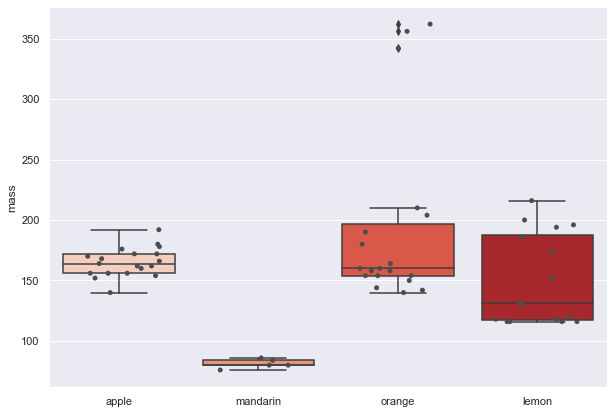

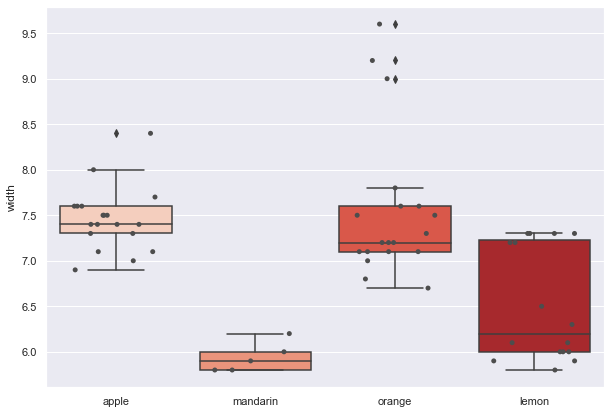

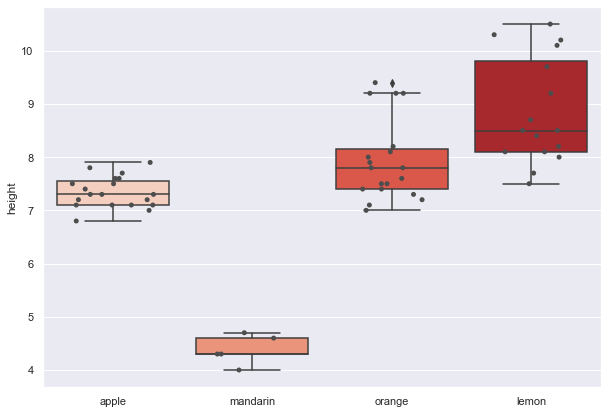

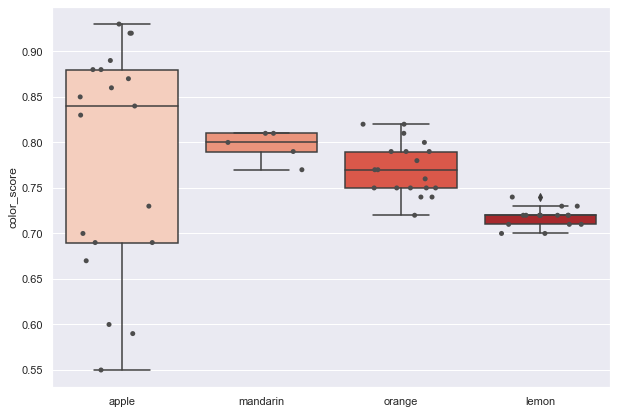

In [90]:
con_feats = df.select_dtypes(include='number').iloc[:,1:].columns
def compare_mean_visual(data, cat_col: str, con_col: str):
    assert(cat_col and con_col in data.columns)
    sns.set(rc={'figure.figsize':(10,7)})
    sns.set_palette("Reds", 4)
    sns.boxplot(x=cat_col, y=con_col, data=data)
    sns.stripplot(x=cat_col, y=con_col, data=data, jitter=0.3, color="0.3")
    plt.xlabel("")
    plt.show()

for feat in con_feats:
    compare_mean_visual(df, cat_col='fruit_name', con_col=feat)    

#### Let's check the number of outliers, because a significant number may affect the relationship

In [6]:
def find_outlier_records(data, column_name: str, no_std=3):
  assert (column_name in data.columns)
  no_outliers = 0 
  values = data[column_name].unique() 
  upper_border = np.asarray(data[column_name]).mean() + no_std*(np.asarray(data[column_name]).std())
  lower_border = np.asarray(data[column_name]).mean() - no_std*(np.asarray(data[column_name]).std()) 
  for value in values:
    if value>upper_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    elif value<lower_border:
      no_outliers+=int(data[column_name].value_counts()[value])
    else:
      continue
  print(f'''Number of outlier records in {column_name} column: {no_outliers}''')  

In [7]:
#Very few
for feat in con_feats:
    find_outlier_records(df, feat)

Number of outlier records in mass column: 3
Number of outlier records in width column: 1
Number of outlier records in height column: 0
Number of outlier records in color_score column: 0


#### Preprocessing and Modeling

In [9]:
df = pd.concat([df.iloc[:,1:2], df.iloc[:,3:]], axis=1) 

In [10]:
df.sample(3)

,fruit_name,mass,width,height,color_score
28,orange,140,6.7,7.1,0.72
33,orange,190,7.5,8.1,0.74
17,apple,168,7.5,7.6,0.73


In [11]:
X = df.iloc[:,1:]
y = df.iloc[:,0] 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15,
                                                    stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50, 4), (50,), (9, 4), (9,))

In [13]:
le = LabelEncoder()
df['fruit_name'] = le.fit_transform(df['fruit_name'])

In [16]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train) 

scaler = RobustScaler()
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)   

In [17]:
d_tree = DecisionTreeClassifier().fit(X_train, y_train)

In [18]:
pred = d_tree.predict(X_test)
pred

array(['lemon', 'orange', 'orange', 'apple', 'lemon', 'orange',
       'mandarin', 'apple', 'orange'], dtype=object)

In [20]:
#A better result would've been reached had we had more data
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       apple       1.00      0.67      0.80         3
       lemon       1.00      1.00      1.00         2
    mandarin       1.00      1.00      1.00         1
      orange       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.94      0.92      0.91         9
weighted avg       0.92      0.89      0.89         9

